In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
import pickle
import os

from amftrack.util.sys import (

    update_plate_info,

    get_current_folders,
)

from amftrack.pipeline.functions.image_processing.experiment_class_surf import (
    Experiment,
)

from amftrack.pipeline.functions.image_processing.experiment_class_surf import (
    Node,
)
from amftrack.pipeline.functions.post_processing.extract_study_zone import (
    load_study_zone,
)
from amftrack.pipeline.functions.post_processing.exp_plot import *
import pickle
import scipy.io as sio
import networkx as nx
import numpy as np
from sthype import SpatialGraph, HyperGraph
from sthype.hypergraph.hypergraph_from_spatial_graphs import spatial_temporal_graph_from_spatial_graphs
import matplotlib.pyplot as plt
import os
import pickle
from tqdm import tqdm
import pandas as pd
from amftrack.pipeline.functions.image_processing.experiment_util import (
    get_all_edges,
    get_all_nodes, get_timedelta_second,
)
from amftrack.pipeline.functions.transport_processing.high_mag_videos.temporal_graph_util import *
mpl.rcParams["figure.dpi"] = 50
import seaborn as sns

c:\users\coren\documents\phd\code\amftrack\amftrack\util\dbx.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
path_root = r"C:\Users\coren\AMOLF-SHIMIZU Dropbox\DATA\CocoTransport\graphs"
plates = [
    "441_20230807", "449_20230807", "310_20230830"
]
plate_id = plates[0]
path_tot = os.path.join(path_root,f"graph{plate_id}.pickle")
spatial_temporal_graph,folders = load(path_tot)

In [3]:
h = HyperGraph(spatial_temporal_graph)

In [5]:
for e in h.edges(data=True):
    print(e)

(29026, 43212, {'center': <POINT (23610.17 3064.663)>, 'edge': {29026, 30191}, 'weight': 337, 'width': 6.217284, 'pixels': [array([23594.8580588 ,  3058.37998716]), array([23595.8580579 ,  3058.37864036]), array([23596.85805699,  3058.37729356]), array([23597.85805608,  3058.37594676]), array([23597.85940288,  3059.37594585]), array([23598.85940198,  3059.37459905]), array([23599.85940107,  3059.37325225]), array([23600.86074697,  3060.37190454]), array([23601.86074606,  3060.37055774]), array([23602.86209195,  3061.36921003]), array([23603.86343785,  3062.36786232]), array([23604.86343694,  3062.36651552]), array([23605.86478284,  3063.36516781]), array([23606.86478193,  3063.36382101]), array([23607.86612782,  3064.3624733 ]), array([23608.86612692,  3064.3611265 ]), array([23609.86612601,  3064.3597797 ]), array([23610.8674719 ,  3065.35843199]), array([23611.867471  ,  3065.35708518]), array([23612.86881689,  3066.35573748]), array([23613.86881599,  3066.35439067]), array([23614.87


KeyboardInterrupt



In [107]:
exp = make_exp(spatial_temporal_graph,folders,make_pixel_list = True)


In [108]:
refs = {
    "310_20230830": {
        "20230901_Plate310": "20230901_0719_Plate06",
        "20230902_Plate310": "20230902_1343_Plate07",
        "20230903_Plate310": "20230903_1143_Plate07",
        "20230904_Plate310": "20230904_0942_Plate07",
        "20230905_Plate310": "20230905_1345_Plate07",
        # "20230906_Plate310" : "20230906_1220_Plate07",
    },
    "441_20230807": {
        "20230810_Plate441": "20230810_1005_Plate14",
        "20230811_Plate441": "20230811_1605_Plate14",
        "20230812_Plate441": "20230812_1006_Plate14",
        "20230813_Plate441": "20230813_1618_Plate14",
    },
    "449_20230807": {
        "20230813_Plate449": "20230813_1606_Plate10",
        "20230814_Plate449": "20230814_1019_Plate10",
        "20230815_Plate449": "20230815_1021_Plate10",
        "20230816_Plate449": "20230816_1027_Plate10",
        # "20230818_Plate449": "20230818_1107_Plate10",
    },
}
indexes = refs[plate_id]

In [109]:
edges_info = [edge for edge in exp.nx_graph[0].edges() if len(spatial_temporal_graph[edge[0]][edge[1]]['video_edge'])]

In [218]:
all_infos = pd.DataFrame()
attribute_list = ["QBC_tot","QBC_net","R","mapping","water_flux","ordered_mapping"]
for edge in edges_info:
    network_edge_infos = spatial_temporal_graph[edge[0]][edge[1]]
    videos = spatial_temporal_graph[edge[0]][edge[1]]['video_edge']
    x1 = spatial_temporal_graph.nodes[edge[0]]['position'].x
    x2 = spatial_temporal_graph.nodes[edge[1]]['position'].x
    
    for folder in videos.keys():
            edge_obj = videos[folder]
            for attribute in attribute_list:
                if folder in network_edge_infos[attribute].keys():
                    edge_obj.mean_data[attribute]=network_edge_infos[attribute][folder]
            edge_data_csv = edge_obj.mean_data
            edge_data_csv['folder'] = folder
            edge_data_csv['edge_network'] = edge
            
            if "water_flux" in edge_data_csv.keys():
                edge_data_csv['ordered_final'] = -edge_data_csv['ordered_mapping']
                
                edge_data_csv['ordered_final'] *= (1-2*(edge[0]>edge[1]))
                edge_data_csv['ordered_final'] *= (1-2*(x1>x2))
                # edge_data_csv['ordered_final'] *= (1-2*(edge_data_csv['water_flux']>0))

            edge_data_csv = pd.DataFrame(edge_data_csv).transpose()
            all_infos = pd.concat([all_infos,edge_data_csv])

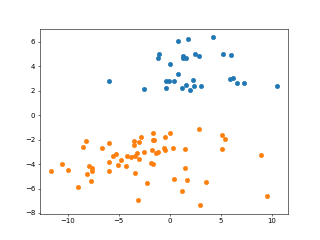

In [221]:
fig,ax = plt.subplots()
select = all_infos[all_infos['mapping']<10]
select = select[select['coverage_tot']>=0.1]
select = select[select['mode']=="BF"]
selectm = select[select['ordered_final']==-1]

ax.scatter(-selectm["water_flux"],selectm["speed_right"])
selectp = select[select['ordered_final']==1]

ax.scatter(-selectp["water_flux"],selectp["speed_left"])

<AxesSubplot: xlabel='water_flux', ylabel='speed_left'>

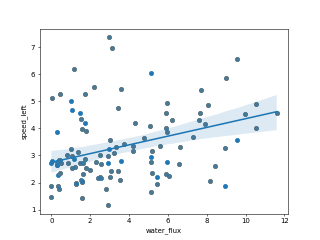

In [217]:
fig,ax = plt.subplots()
select = all_infos[all_infos['mapping']<10]
select = select[select['coverage_tot']>=0.1]
select = select[select['mode']=="BF"]
selectm = select[select['ordered_final']==1]

ax.scatter(np.abs(selectm["water_flux"]),selectm["speed_right"])
selectp = select[select['ordered_final']==-1]
selectp = select[select['speed_left']<0]

ax.scatter(np.abs(selectp["water_flux"]),np.abs(selectp["speed_left"]))
sns.regplot(x = np.abs(selectp["water_flux"]).astype("float"),y=np.abs(selectp["speed_left"]).astype("float"))

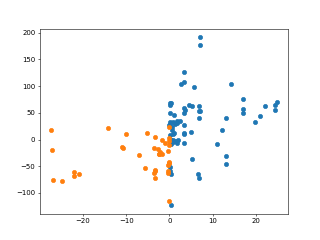

In [224]:
fig,ax = plt.subplots()
select = all_infos[all_infos['mapping']<10]
select = select[select['coverage_tot']>=0.1]
select = select[select['QBC_tot']>0]

select = select[select['mode']=="F"]
selectm = select[select['ordered_final']==1]

ax.scatter(selectm["QBC_net"],selectm["flux_avg"])
selectp = select[select['ordered_final']==-1]
# selectp = select[select['speed_left']<0]

ax.scatter(selectp["QBC_net"],-selectp["flux_avg"])


In [230]:
np.sign((all_infos['flux_avg']*all_infos["QBC_net"]*all_infos["ordered_final"]).astype(float))

0    NaN
0    0.0
0    0.0
0    1.0
0    0.0
    ... 
0    0.0
0    0.0
0    0.0
0    1.0
0    1.0
Length: 645, dtype: float64

In [231]:
all_infos['aligned'] = np.sign((all_infos['flux_avg']*all_infos["QBC_net"]*all_infos["ordered_final"]).astype(float))

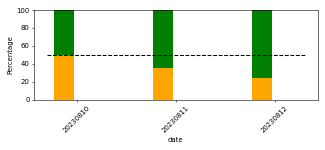

In [234]:
# Assuming 'select' is your DataFrame filtered based on previous conditions.
plate_ids = all_infos['plate_id'].unique()
plate_ids_names = [plate_id.split("_")[0] for plate_id in plate_ids]
num_plate_ids = len(plate_ids)

# Prepare figure
fig, ax = plt.subplots(figsize=(10/2 + num_plate_ids/2, 3))  # Adjust figure size based on the number of plate_ids

# Bar plot settings
bar_width = 0.2
index = np.arange(num_plate_ids)
color_1 = 'orange'
color_2 = 'green'

# Initialize containers for bar positions and heights
positions_1 = []
positions_2 = []
heights_1 = []
heights_2 = []

# Loop through each plate_id to get proportions
for i, plate_id in enumerate(plate_ids):
    subset = all_infos[all_infos['plate_id'] == plate_id]
    subset = subset[(subset['coverage_tot'] > 0.05) & 
               (subset['speed_right'] <= 15) & 
               (subset['mode'] <= "F") & 
               (subset['mapping'] <= 10) &
               (subset['QBC_tot'] > 0) 
                    
                   ]
    aligned_counts = subset['aligned'].value_counts(normalize=True).reindex([-1, 1], fill_value=0) * 100
    # aligned2_counts = subset['aligned2'].value_counts(normalize=True).reindex([-1, 1], fill_value=0) * 100
    
    # Plot bars for this plate_id
    pos_1 = index[i] - bar_width/1.5
    pos_2 = index[i] + bar_width/1.5
    
    positions_1.append(pos_1)
    positions_2.append(pos_2)
    heights_1.extend([aligned_counts[-1], aligned_counts[1]])
    # heights_2.extend([aligned2_counts[-1], aligned2_counts[1]])
    
    ax.bar(pos_1, aligned_counts[-1], bar_width, label='-1 in Aligned' if i == 0 else "", color=color_1)
    ax.bar(pos_1, aligned_counts[1], bar_width, bottom=aligned_counts[-1], label='1 in Aligned' if i == 0 else "", color=color_2)
    
#     ax.bar(pos_2, aligned2_counts[-1], bar_width, label='-1 in Aligned2' if i == 0 else "", color=color_1,hatch = "/")
#     ax.bar(pos_2, aligned2_counts[1], bar_width, bottom=aligned2_counts[-1], label='1 in Aligned2' if i == 0 else "", color=color_2,hatch = "/")

# Add labels, title, and custom x-axis tick labels
ax.set_xlabel('date')
ax.set_ylabel('Percentage')
# ax.set_title('Proportion of -1 and 1 in Aligned and Aligned2 by Plate ID')
ax.set_xticks(index)
ax.set_xticklabels(plate_ids_names, rotation=45)
ax.set_ylim(0, 100)
ax.hlines(50,-bar_width*1.5,len(index)-1+bar_width*1.5,color="black",linestyle="dashed")
# ax.legend()

plt.tight_layout()
plt.show()

In [195]:
selectm.iloc[0]['folder']

'20230810_1005_Plate14'

In [196]:
selectm.iloc[0]['video_int']

52

In [202]:
selectm.iloc[0]['speed_right']

1.8756338

In [197]:
selectm.iloc[0]['edge_name']

'(33, 9)'

In [198]:
len(selectm)+len(selectp)

90

In [119]:
selectm['folder'].unique()

array(['20230810_1005_Plate14', '20230812_1006_Plate14',
       '20230811_1605_Plate14'], dtype=object)

In [194]:
select = all_infos.loc[all_infos['video_int']==52]
select = select.loc[select['edge_name']=="(33, 9)"]
select['water_flux'],select['speed_left'],select['speed_right'],select["ordered_final"]

(0   -8.920919
 Name: water_flux, dtype: object,
 0   -3.258193
 Name: speed_left, dtype: object,
 0    1.875634
 Name: speed_right, dtype: object,
 0    1
 Name: ordered_final, dtype: object)

In [199]:
select['ordered_mapping'],select['edge_network']

(0    -1
 Name: ordered_mapping, dtype: object,
 0    (181405, 181410)
 Name: edge_network, dtype: object)

In [168]:
edge = select['edge_network'].iloc[0]
edge

(13287, 292634)

In [200]:
x1 = spatial_temporal_graph.nodes[edge[0]]['position'].x
x2 = spatial_temporal_graph.nodes[edge[1]]['position'].x
x1,x2

(8893.434875058863, 8937.60711182567)

In [203]:
nodes = [Node(label,exp) for label in select['edge_network'].iloc[0]]
nodes

[Node(181405), Node(181410)]

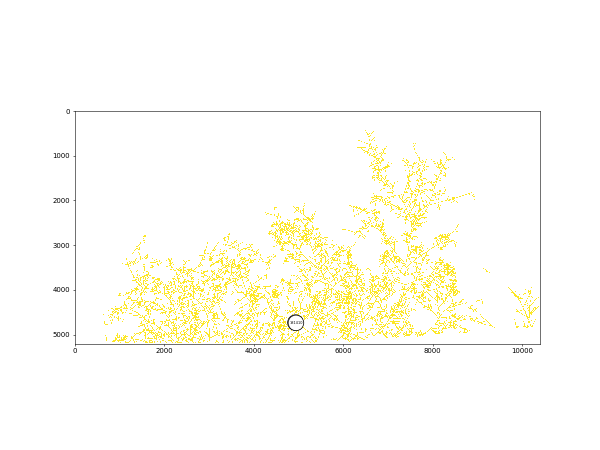

In [204]:
from amftrack.pipeline.functions.transport_processing.high_mag_videos.plotting import *
from matplotlib import cm
downsizing = 5
t=0

fig, ax,f = plot_edge_color_value_3(
    exp,
    t,
    lambda edge : 2,
    cmap=cm.get_cmap("viridis", 100),
    plot_cmap=True,
    show_background=False,
    dilation=10,
    figsize=(12, 9),
    alpha = 1,
    v_min = 0,
    v_max = 0.2,
    region = region,
    nodes = nodes

)

In [61]:
all_infos['ordered']

0     1
0     1
0     1
0    -1
0     1
     ..
0    -1
0     1
0     1
0     1
0     1
Name: ordered, Length: 645, dtype: object

In [ ]:
G = exp1.nx_graph[0]
speeds = [abs(G[u][v]['speed']) for u, v in G.edges()]
fluxes = [G[u][v]['QBC_net'] for u, v in G.edges()]
fig,ax = plt.subplots()
ax.hist(speeds,30)
# ax.hist(fluxes2,30,alpha = 0.5)
ax.set_yscale("log")

In [144]:
from amftrack.pipeline.functions.transport_processing.high_mag_videos.plotting import *
from matplotlib import cm
downsizing = 5
t=0
region = [[0*5,0*5],[26000,52000]]

fig, ax,f = plot_edge_color_value_3(
    exp1,
    t,
    lambda edge : abs(edge.get_attribute("speed",t)),
    cmap=cm.get_cmap("viridis", 100),
    plot_cmap=True,
    show_background=False,
    dilation=10,
    figsize=(5, 3),
    alpha = 1,
    v_min = 0,
    v_max = 0.2,
    region = region
    # nodes = non_zero

)

NameError: name 'exp1' is not defined

In [ ]:
region = [[3750*5,4500*5],[5250*5,8000*5]]

plot_region(exp1,region,"water_flux",0.3)